# 中间件

你在用django开发项目的时候，只要是设计到全局相关的功能都可以使用中间件方便的完成。
- 全局用户身份校验
- 全局用户权限校验
- 全局访问频率校验

```
MIDDLEWARE = [
    'django.middleware.security.SecurityMiddleware',
    'django.contrib.sessions.middleware.SessionMiddleware',
    'django.middleware.common.CommonMiddleware',
    'django.middleware.csrf.CsrfViewMiddleware',
    'django.contrib.auth.middleware.AuthenticationMiddleware',
    'django.contrib.messages.middleware.MessageMiddleware',
    'django.middleware.clickjacking.XFrameOptionsMiddleware',
]
```

django支持程序员自定义中间件并且暴露给程序员五个可以自定义的方法
1. 必须掌握
    
    process_request
    
    process_response
    
2. 了解即可

    process_view
    
    process_template_response
    
    process_exception

# 自定义中间件流程

1. 在项目名或者应用名下创建一个任意名称的文件夹
2. 在该文件夹内创建一个任意名称的py文件
3. 在该py文件内需要书写类（这个类必须继承MiddlewareMixin）,然后在这个类里就可以自定义五个方法了（）不需要全部书写五个方法，用到几个写几个）。
4. 需要将类的路径以字符串的形式注册到配置文件中才能生效

# 自定义方法详细

## process_request

1. 请求来的时候需要经过每一个中间件里面的process_request方法，调用的顺序是按照配置文件中注册中加减从上往下的顺序依次执行。
2. 如果中间件里面没有定义该方法，那么直接跳过执行下一个中间件
3. 如果该方法反悔了HttpResponse对象，那么请求将不再继续往后执行，而是直接原路返回（校验失败不允许访问）。

process_request方法就是用来做全局相关的所有限制功能

## process_response

1. 响应走的时候需要经过每一个中间件里面的process_response方法，该方法有两个额外的参数，request response, response 就是后端返回的三板斧。
2. 该方法返回一个HttpResponse对象，默认返回的就是形参response，也可以返回自己的。
3. 经过顺序是按照配置文件中注册了的中间件从下往上依次经过，如果没有定义的话，直接跳过执行下一个。

## process_view

在路由匹配成功之后，视图函数执行之前，自动触发执行中间件中该方法。

## 了解方法

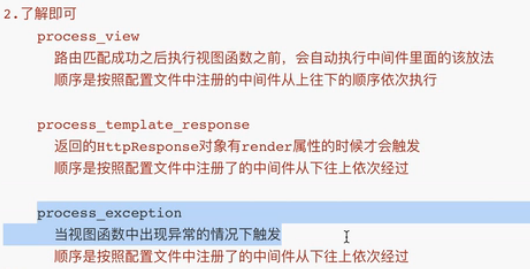

# csrf 跨站请求伪造

csrf跨站请求伪造校验：

    网站在给用户返回一个具有提交数据功能页面的时候会给这个页面加一个唯一标识，当这个页面朝后端发送post请求时，后端就会先校验这个唯一标识，如果唯一标识不对，直接拒绝(403 forbbiden),如果成功则正常执行

form表单如何符合校验:

在form中任意位置添加{% csrf_token %}即可
```
<form action="" method="post">
{% csrf_token %}
</form>
```


ajax 符合校验的三种方式

```
{% load static %}
<script src="{% static 'js/mysetup.js' %}"></script>  已进入django提供的js文件
<script>
    $('#d1').click(function () {
        $.ajax({
            url:'',
            # 第一种
            data:'{'csrfmiddlewaretoken':$('[name=csrfmiddlewaretooken]').val()}',
            # 第二种，不能用于前后端分离
            'data':{'scrfmiddlewaretoken':'{{ csrf_token }}'},
            # 第三种，通用方式，配置django官方提供的js文件即可,拷贝固定js代码导入到html页面即可
        })
    })
</script>
```

# csrf 相关装饰器

```
from django.views.decorators.csrf import protect,csrf_exempt

csrf_protect 需要校验
csrf_exempt 忽略校验

# 注释掉settings.py配置文件后，整体不校验，只有某个特定的视图函数需要校验
@csrf_protect
def test(request):
    return HttpResponse('ok')
    
# 对几个制定的视图函数忽略csrf校验
@csrf_exempt
def test(request):
    return HttpResponse('ok')

```

CBV

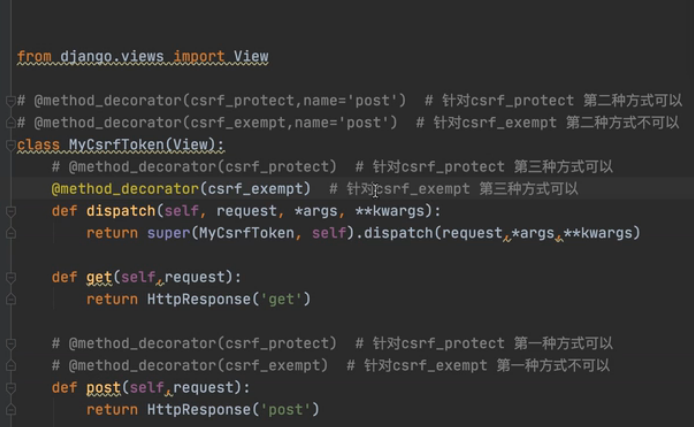

```
csrf_protect 需要校验
    之前所学CBV装饰器的三种方式可行
csrf_exempt 忽略校验
    只能加给dispatch方法才有效

```

# 新模块介绍

```
import importlib
res = 'myfile.b'
ret = importlib.import_module(res) # 等价于 from myfile import b
该方法最小只能到py文件名
```

# 学习中间件的编程思想

在 settings.py 文件中，**MIDDLEWARE**中的几个中间件功能，只要注释掉，这个功能就不会被调用，如我们常常会注释掉其中的csrf模块，在提交post请求时就不用被校验。

需求：一个通知功能，通过qq，wechat，email发送通知，当注释掉配置文件中某一个发送通知的方式时，如qq，qq就不会发送通知。

代码实现：

test/notify/settings.py配置文件

```
NOTIFY_TYPE=[
    'test.notify.email.Email',
    'test.notify.qq.QQ',
    'test.notify.wechat.Wechat'
]
```

发送通知 test/start.py文件

```
from test import notify

notify.send_all('下班吃饭')
```

发送功能实现模块

`test/notify/__init__.py`
```
from .set import NOTIFY_TYPE
import importlib

def send_all(content):
    for path_str in NOTIFY_TYPE:
        import_path, class_name = path_str.rsplit('.', maxsplit=1)
        models = importlib.import_module(import_path)
        cls = getattr(models, class_name)
        obj = cls()
        obj.send(content)
```

qq发送功能test/notify/qq.py
```
class QQ():
    def __init__(self):
        # 发送qq的前期准备工作在此完成
        pass

    def send(self, content):
        print("qq: ", content)
```

wechat发送功能test/notify/wechat.py
```
class Wechat():
    def __init__(self):
        pass

    def send(self, content):
        print("wehcat: ", content)
```

email发送功能test/notify/email.py
```
class Email():
    def __init__(self):
        pass

    def send(self, content):
        print("email: ", content)
```

根据不同的功能创建不同的py文件，写不同的功能类，均有同一个方法(send)，根据鸭子类型类编写多个功能类，在配置文件中注释掉对应的功能字符串，其相应的功能也就取消掉了。